## Imports & functions

In [1]:
%cd ../lvlm-interpret
import os

try:
    os.environ["PT_HPU_LAZY_MODE"] = "0"
    import habana_frameworks.torch.core as htcore 
    device_map = "hpu"
except ImportError:
    device_map = "auto"

device_map = "cuda:0"
    
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.cm as cm

from argparse import Namespace

import torch
import requests
import numpy as np

import cv2
from PIL import Image

/repo/medical-lvlm-interpret/lvlm-interpret


In [2]:
import utils_model
import utils_gradio
import utils_attn

/root/miniconda/envs/llava-lvlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import set_seed, logging

logging.set_verbosity_error()

In [4]:
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def draw_ellipses(img, bboxes):
    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap="gray")
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        # Calculate center, width, and height
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min
        color = 'orange'
        # Create and add the ellipse patch
        ellipse_patch = patches.Ellipse((x_center, y_center), width, height, linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(ellipse_patch)
    plt.show()

def is_signal_within_ellipse(bin_rel_map: torch.Tensor,
                              image_shape: tuple,
                              xmin: float, ymin: float, xmax: float, ymax: float) -> bool:
    rel_h, rel_w = bin_rel_map.shape
    img_h, img_w = image_shape[:2]

    # Scale bbox to match rel map dimensions
    x0 = int(xmin * rel_w / img_w)
    x1 = int(xmax * rel_w / img_w)
    y0 = int(ymin * rel_h / img_h)
    y1 = int(ymax * rel_h / img_h)

    x0, x1 = max(0, x0), min(rel_w, x1)
    y0, y1 = max(0, y0), min(rel_h, y1)

    region = bin_rel_map[y0:y1, x0:x1].cpu().numpy()

    # Check if any signal lies within the ellipse
    return np.any(region)

## LLaVA-Med example

In [5]:
model_name_or_path = "microsoft/llava-med-v1.5-mistral-7b"

args = Namespace(
    model_name_or_path=model_name_or_path,
    device_map=device_map,
)

In [6]:
tokenizer, image_processor, model = utils_model.get_tokenizer_processor_model(args)

utils_gradio.processor = image_processor
utils_gradio.model = model

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.72s/it]


In [8]:
# Provide input prompt and filepath to the image
prompt = "Which pathology is present on the chest radiograph?"
image_file = "../notebooks/img/cxr_example.jpg"
raw_image = Image.open(image_file)

state, _, _, _ = utils_gradio.add_text_med(None, prompt, raw_image)

In [9]:
temperature = 0.2
top_p = 0.7
max_new_tokens = 15

state, _ = utils_gradio.lvlm_med_bot(tokenizer, state, temperature, top_p, max_new_tokens, device_map)

The chest radiograph shows the presence of pneumonia. </s>


Building relevancy maps: 100%|█████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.62it/s]


In [10]:
type_selector = 'llama'
fn_attention = state.attention_key + '_relevancy.pt'
recovered_image = state.recovered_image
img_idx = state.image_idx
word_rel_maps = torch.load(fn_attention)

word_rel_map = word_rel_maps[type_selector]
image_list = []

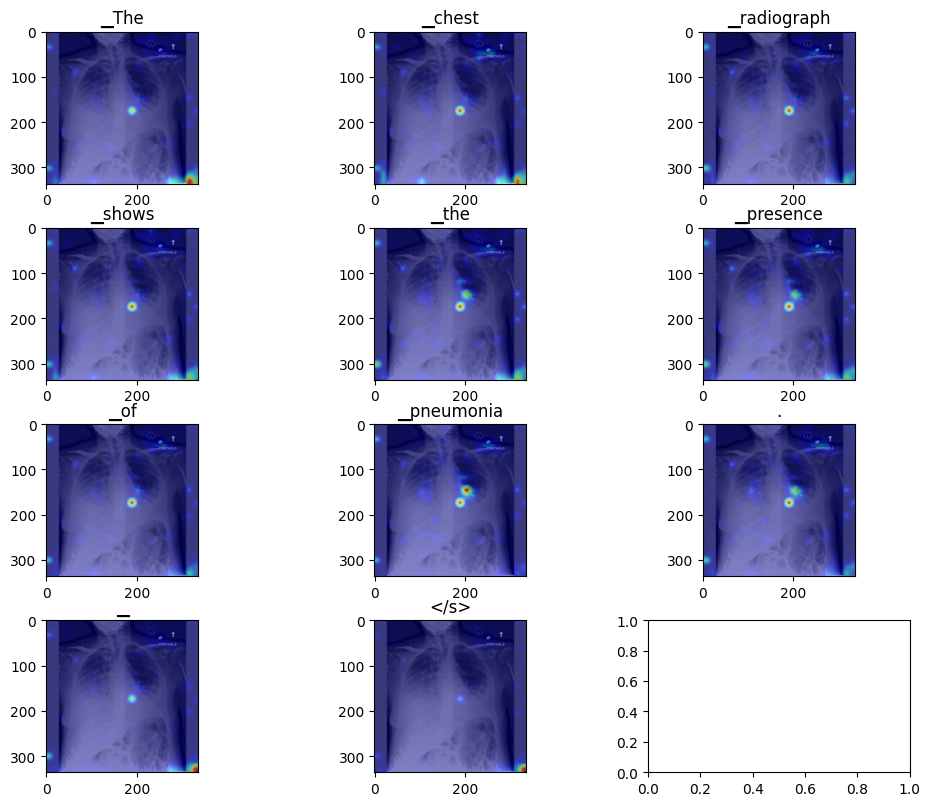

In [13]:
fig, axes = plt.subplots(4, 3, figsize=(10,8))
fig.tight_layout()

for ax, (rel_key, rel_map) in zip(axes.ravel(), word_rel_map.items()):
    if (rel_map.shape[-1] != 577):
        rel_map = rel_map[-1,:][img_idx:img_idx+576].reshape(1,1,24,24).float()
    else:
        rel_map = rel_map[0,1:].reshape(1,1,24,24).float()
        
    rel_map_upscaled = torch.nn.functional.interpolate(rel_map, scale_factor=14, mode='bilinear')
    rel_map_upscaled = (rel_map_upscaled - rel_map_upscaled.min()) / (rel_map_upscaled.max() - rel_map_upscaled.min())
    rel_map_upscaled = rel_map_upscaled.squeeze(0).squeeze(0)
    
    original_image = np.array(recovered_image)
    original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
    vis = show_cam_on_image(original_image, rel_map_upscaled.cpu().numpy())
    ax.imshow(vis)
    ax.set_title(f'{rel_key}')

### Pneumonia localization

In [14]:
anomaly_rel_map = word_rel_map['▁pneumonia']
rel_map = anomaly_rel_map[-1,:][img_idx:img_idx+576].reshape(1,1,24,24).float()
rel_map_upscaled = torch.nn.functional.interpolate(rel_map, scale_factor=14, mode='bilinear')
rel_map_upscaled = (rel_map_upscaled - rel_map_upscaled.min()) / (rel_map_upscaled.max() - rel_map_upscaled.min())
rel_map_upscaled = rel_map_upscaled.squeeze(0).squeeze(0)

In [15]:
rel_map_upscaled.min(), rel_map_upscaled.max()

(tensor(0.), tensor(1.))

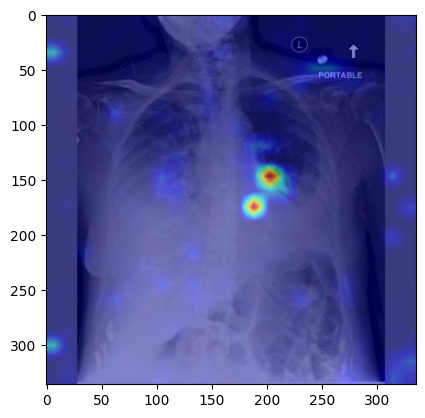

In [16]:
original_image = np.array(recovered_image)
original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
vis = show_cam_on_image(original_image, rel_map_upscaled.cpu().numpy())
plt.imshow(vis)
plt.show()

In [17]:
bin_rel_map_upscaled = rel_map_upscaled > 0.1

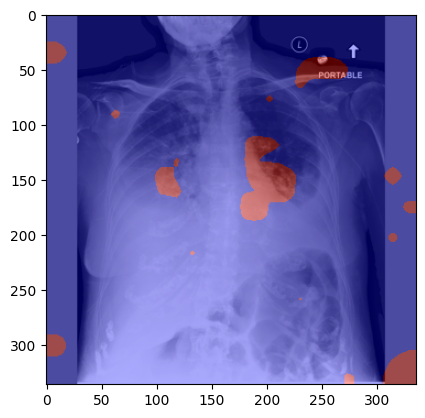

In [18]:
original_image = np.array(recovered_image)
original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
vis = show_cam_on_image(original_image, bin_rel_map_upscaled.cpu().numpy())
plt.imshow(vis)
plt.show()

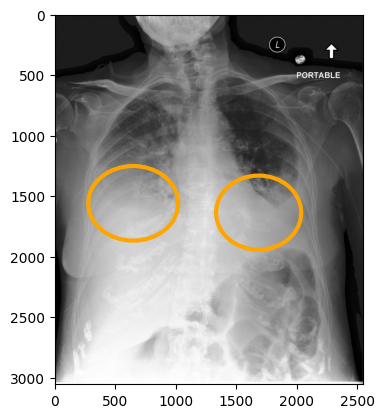

In [19]:
# consolidation in cxr_example (fa771fa1-d9571d07-bff8f655-327734a7-6e10b29d)
draw_ellipses(raw_image, bboxes=[(276, 1251, 1019, 1868), (1333, 1330, 2036, 1943)])

In [20]:
is_signal_within_ellipse(bin_rel_map_upscaled, raw_image.size, 1333, 1330, 2036, 1943)

True

In [21]:
is_signal_within_ellipse(bin_rel_map_upscaled, raw_image.size, 276, 1251, 1019, 1868)

False

In [22]:
torch.cuda.empty_cache() 